# MINI PROJECT

In [ ]:
# 0. import
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils, models
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

## Baseline

In [36]:
# hyperparameters
BATCH_SIZE = 128
DEVICE = ("mps" if torch.backends.mps.is_available() else "cpu")
NUM_EPOCHS = 30

In [23]:
transform_baseline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset_baseline = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_baseline)
testset_baseline = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_baseline)

train_loader_baseline = torch.utils.data.DataLoader(trainset_baseline, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader_baseline = torch.utils.data.DataLoader(testset_baseline, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Files already downloaded and verified
Files already downloaded and verified


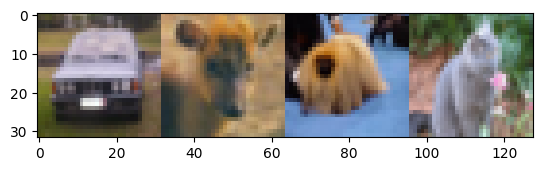

Class labels:  car   deer  dog   cat  


In [24]:
# show some examples
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader_baseline)
images, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [33]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

model.fc = nn.Linear(model.fc.in_features, 10) # 10 classes
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10,
    T_mult=2,
    eta_min=0.0001
)

In [67]:
def test(model, test_loader, criterion):
    correct = 0
    total = 0
    avg_test_loss = 0.0
   
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = model(images)
            max_prob, max_idx = torch.max(outputs.data, 1)
            total += labels.size(0) # batch size ... 전체 개수 더하기
            correct += (max_idx == labels).sum().item() # 예측 맞은 개수
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(test_loader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [68]:
def train(model, criterion, optimizer, num_epochs, train_loader, test_loader):
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0

        model.train()

        for i, (imgs, label) in tqdm(enumerate(train_loader, 0)):
            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            imgs = imgs.to(DEVICE)
            labels = label.to(DEVICE)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            outputs = model(imgs) # forward
            loss = criterion(outputs, labels)
            loss.backward() # backward
            optimizer.step() # optimize

            scheduler.step()
            # TODO: Get predicted results
            max_prob, max_idx = torch.max(outputs, 1)
            predicted = max_idx.to(DEVICE)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        model.eval() # Set the model to the evaluation mode.
        test(model, test_loader, criterion)
        
    print('Finished Training')

In [69]:
train(model, criterion, optimizer, num_epochs=NUM_EPOCHS, train_loader=train_loader_baseline, test_loader=test_loader_baseline)

# Loss 곡선 그리면 좋을 듯.

104it [00:04, 23.35it/s]

[1,   100] loss: 1.112 acc: 60.12


203it [00:08, 23.31it/s]

[1,   200] loss: 0.989 acc: 64.28


302it [00:13, 23.29it/s]

[1,   300] loss: 0.938 acc: 66.72


391it [00:16, 23.26it/s]
100%|██████████| 391/391 [00:06<00:00, 56.70it/s]


TESTING:
Accuracy of the network on the 10000 test images: 72.01 %
Average loss on the 10000 test images: 0.792


103it [00:06, 17.39it/s]

[2,   100] loss: 0.790 acc: 72.26


203it [00:12, 18.00it/s]

[2,   200] loss: 0.995 acc: 64.84


303it [00:18, 17.81it/s]

[2,   300] loss: 0.968 acc: 66.27


391it [00:22, 17.07it/s]
100%|██████████| 391/391 [00:06<00:00, 57.78it/s]


TESTING:
Accuracy of the network on the 10000 test images: 68.95 %
Average loss on the 10000 test images: 0.874


104it [00:04, 23.32it/s]

[3,   100] loss: 0.850 acc: 70.51


203it [00:08, 23.19it/s]

[3,   200] loss: 0.813 acc: 72.03


302it [00:13, 23.19it/s]

[3,   300] loss: 0.791 acc: 72.00


391it [00:16, 23.17it/s]
100%|██████████| 391/391 [00:06<00:00, 58.78it/s]


TESTING:
Accuracy of the network on the 10000 test images: 77.13 %
Average loss on the 10000 test images: 0.653


102it [00:04, 20.71it/s]

[4,   100] loss: 0.636 acc: 77.47


204it [00:09, 19.98it/s]

[4,   200] loss: 0.626 acc: 78.17


302it [00:14, 18.43it/s]

[4,   300] loss: 0.598 acc: 79.28


391it [00:19, 20.02it/s]
100%|██████████| 391/391 [00:06<00:00, 57.62it/s]


TESTING:
Accuracy of the network on the 10000 test images: 83.99 %
Average loss on the 10000 test images: 0.472


102it [00:04, 23.12it/s]

[5,   100] loss: 0.471 acc: 84.18


204it [00:08, 23.24it/s]

[5,   200] loss: 0.467 acc: 83.95


303it [00:13, 23.23it/s]

[5,   300] loss: 0.735 acc: 74.55


391it [00:16, 23.17it/s]
100%|██████████| 391/391 [00:06<00:00, 57.90it/s]


TESTING:
Accuracy of the network on the 10000 test images: 71.41 %
Average loss on the 10000 test images: 0.816


102it [00:04, 23.22it/s]

[6,   100] loss: 0.711 acc: 75.00


204it [00:08, 23.26it/s]

[6,   200] loss: 0.729 acc: 75.15


303it [00:13, 23.22it/s]

[6,   300] loss: 0.712 acc: 74.88


391it [00:17, 22.62it/s]
100%|██████████| 391/391 [00:06<00:00, 57.98it/s]


TESTING:
Accuracy of the network on the 10000 test images: 80.03 %
Average loss on the 10000 test images: 0.566


102it [00:04, 23.16it/s]

[7,   100] loss: 0.565 acc: 80.41


204it [00:08, 23.23it/s]

[7,   200] loss: 0.616 acc: 78.19


303it [00:13, 23.23it/s]

[7,   300] loss: 0.603 acc: 78.93


391it [00:17, 22.71it/s]
100%|██████████| 391/391 [00:06<00:00, 57.91it/s]


TESTING:
Accuracy of the network on the 10000 test images: 84.21 %
Average loss on the 10000 test images: 0.462


102it [00:04, 23.21it/s]

[8,   100] loss: 0.467 acc: 83.80


204it [00:08, 23.21it/s]

[8,   200] loss: 0.478 acc: 83.20


303it [00:13, 23.24it/s]

[8,   300] loss: 0.472 acc: 83.61


391it [00:17, 22.72it/s]
100%|██████████| 391/391 [00:06<00:00, 57.78it/s]


TESTING:
Accuracy of the network on the 10000 test images: 88.91 %
Average loss on the 10000 test images: 0.330


102it [00:04, 23.21it/s]

[9,   100] loss: 0.316 acc: 89.06


204it [00:08, 23.23it/s]

[9,   200] loss: 0.329 acc: 88.73


303it [00:13, 23.22it/s]

[9,   300] loss: 0.312 acc: 89.05


391it [00:16, 23.02it/s]
100%|██████████| 391/391 [00:06<00:00, 57.98it/s]


TESTING:
Accuracy of the network on the 10000 test images: 94.34 %
Average loss on the 10000 test images: 0.182


102it [00:04, 23.23it/s]

[10,   100] loss: 0.182 acc: 94.12


204it [00:08, 23.30it/s]

[10,   200] loss: 0.175 acc: 94.23


303it [00:13, 23.24it/s]

[10,   300] loss: 0.165 acc: 94.55


391it [00:17, 22.28it/s]
100%|██████████| 391/391 [00:06<00:00, 57.67it/s]


TESTING:
Accuracy of the network on the 10000 test images: 98.04 %
Average loss on the 10000 test images: 0.077


102it [00:04, 23.22it/s]

[11,   100] loss: 0.090 acc: 97.52


204it [00:08, 23.20it/s]

[11,   200] loss: 0.088 acc: 97.55


303it [00:13, 23.25it/s]

[11,   300] loss: 0.082 acc: 97.62


391it [00:16, 23.22it/s]
100%|██████████| 391/391 [00:06<00:00, 58.57it/s]


TESTING:
Accuracy of the network on the 10000 test images: 98.78 %
Average loss on the 10000 test images: 0.055


102it [00:04, 23.25it/s]

[12,   100] loss: 0.441 acc: 85.14


204it [00:08, 23.22it/s]

[12,   200] loss: 0.616 acc: 78.67


303it [00:13, 23.25it/s]

[12,   300] loss: 0.602 acc: 79.07


391it [00:16, 23.21it/s]
100%|██████████| 391/391 [00:06<00:00, 57.57it/s]


TESTING:
Accuracy of the network on the 10000 test images: 84.56 %
Average loss on the 10000 test images: 0.450


102it [00:04, 23.23it/s]

[13,   100] loss: 0.440 acc: 84.49


204it [00:08, 23.27it/s]

[13,   200] loss: 0.488 acc: 82.96


303it [00:13, 23.28it/s]

[13,   300] loss: 0.468 acc: 83.73


391it [00:16, 23.24it/s]
100%|██████████| 391/391 [00:06<00:00, 58.78it/s]


TESTING:
Accuracy of the network on the 10000 test images: 87.17 %
Average loss on the 10000 test images: 0.367


102it [00:04, 23.22it/s]

[14,   100] loss: 0.365 acc: 87.16


204it [00:08, 23.25it/s]

[14,   200] loss: 0.398 acc: 86.11


303it [00:13, 23.21it/s]

[14,   300] loss: 0.416 acc: 85.53


391it [00:16, 23.22it/s]
100%|██████████| 391/391 [00:06<00:00, 58.52it/s]


TESTING:
Accuracy of the network on the 10000 test images: 88.04 %
Average loss on the 10000 test images: 0.350


102it [00:04, 23.24it/s]

[15,   100] loss: 0.290 acc: 89.99


204it [00:08, 23.26it/s]

[15,   200] loss: 0.332 acc: 88.59


303it [00:13, 23.20it/s]

[15,   300] loss: 0.326 acc: 88.59


391it [00:17, 22.71it/s]
100%|██████████| 391/391 [00:06<00:00, 56.54it/s]


TESTING:
Accuracy of the network on the 10000 test images: 92.83 %
Average loss on the 10000 test images: 0.213


102it [00:04, 23.21it/s]

[16,   100] loss: 0.210 acc: 92.79


204it [00:08, 23.17it/s]

[16,   200] loss: 0.248 acc: 91.52


303it [00:13, 23.20it/s]

[16,   300] loss: 0.264 acc: 90.89


391it [00:17, 22.96it/s]
100%|██████████| 391/391 [00:06<00:00, 58.03it/s]


TESTING:
Accuracy of the network on the 10000 test images: 94.61 %
Average loss on the 10000 test images: 0.162


102it [00:04, 23.22it/s]

[17,   100] loss: 0.161 acc: 94.42


204it [00:08, 23.12it/s]

[17,   200] loss: 0.185 acc: 93.42


303it [00:13, 23.25it/s]

[17,   300] loss: 0.192 acc: 93.21


391it [00:17, 22.65it/s]
100%|██████████| 391/391 [00:06<00:00, 57.49it/s]


TESTING:
Accuracy of the network on the 10000 test images: 95.28 %
Average loss on the 10000 test images: 0.137


102it [00:04, 23.23it/s]

[18,   100] loss: 0.106 acc: 96.41


204it [00:08, 23.27it/s]

[18,   200] loss: 0.109 acc: 96.17


303it [00:13, 23.09it/s]

[18,   300] loss: 0.137 acc: 95.47


391it [00:16, 23.03it/s]
100%|██████████| 391/391 [00:09<00:00, 42.25it/s]


TESTING:
Accuracy of the network on the 10000 test images: 98.11 %
Average loss on the 10000 test images: 0.058


102it [00:07, 15.04it/s]

[19,   100] loss: 0.070 acc: 97.74


202it [00:13, 15.03it/s]

[19,   200] loss: 0.058 acc: 98.03


302it [00:20, 15.07it/s]

[19,   300] loss: 0.068 acc: 97.65


391it [00:26, 14.87it/s]
100%|██████████| 391/391 [00:06<00:00, 57.22it/s]


TESTING:
Accuracy of the network on the 10000 test images: 99.16 %
Average loss on the 10000 test images: 0.028


102it [00:04, 23.24it/s]

[20,   100] loss: 0.036 acc: 98.83


204it [00:08, 23.24it/s]

[20,   200] loss: 0.034 acc: 98.91


303it [00:13, 23.23it/s]

[20,   300] loss: 0.032 acc: 98.86


391it [00:17, 22.63it/s]
100%|██████████| 391/391 [00:06<00:00, 57.69it/s]


TESTING:
Accuracy of the network on the 10000 test images: 99.72 %
Average loss on the 10000 test images: 0.012


102it [00:04, 22.80it/s]

[21,   100] loss: 0.015 acc: 99.62


204it [00:08, 23.26it/s]

[21,   200] loss: 0.013 acc: 99.67


303it [00:13, 23.25it/s]

[21,   300] loss: 0.012 acc: 99.66


391it [00:17, 22.55it/s]
100%|██████████| 391/391 [00:06<00:00, 57.69it/s]


TESTING:
Accuracy of the network on the 10000 test images: 99.99 %
Average loss on the 10000 test images: 0.002


102it [00:04, 23.20it/s]

[22,   100] loss: 0.006 acc: 99.86


204it [00:08, 23.20it/s]

[22,   200] loss: 0.004 acc: 99.97


303it [00:13, 23.26it/s]

[22,   300] loss: 0.004 acc: 99.93


391it [00:17, 22.62it/s]
100%|██████████| 391/391 [00:06<00:00, 57.84it/s]


TESTING:
Accuracy of the network on the 10000 test images: 100.00 %
Average loss on the 10000 test images: 0.001


102it [00:04, 22.78it/s]

[23,   100] loss: 0.003 acc: 99.95


204it [00:08, 23.23it/s]

[23,   200] loss: 0.003 acc: 99.98


303it [00:13, 23.23it/s]

[23,   300] loss: 0.002 acc: 99.99


391it [00:17, 22.56it/s]
100%|██████████| 391/391 [00:06<00:00, 57.41it/s]


TESTING:
Accuracy of the network on the 10000 test images: 100.00 %
Average loss on the 10000 test images: 0.001


102it [00:04, 23.21it/s]

[24,   100] loss: 0.002 acc: 99.98


204it [00:08, 23.21it/s]

[24,   200] loss: 0.002 acc: 99.99


303it [00:13, 23.24it/s]

[24,   300] loss: 0.002 acc: 99.99


391it [00:17, 22.67it/s]
100%|██████████| 391/391 [00:06<00:00, 57.82it/s]


TESTING:
Accuracy of the network on the 10000 test images: 100.00 %
Average loss on the 10000 test images: 0.001


102it [00:04, 23.05it/s]

[25,   100] loss: 0.084 acc: 98.20


204it [00:08, 23.27it/s]

[25,   200] loss: 0.906 acc: 69.25


303it [00:13, 23.24it/s]

[25,   300] loss: 0.601 acc: 79.27


391it [00:17, 22.50it/s]
100%|██████████| 391/391 [00:06<00:00, 57.40it/s]


TESTING:
Accuracy of the network on the 10000 test images: 82.00 %
Average loss on the 10000 test images: 0.508


102it [00:04, 23.29it/s]

[26,   100] loss: 0.420 acc: 85.31


204it [00:08, 23.18it/s]

[26,   200] loss: 0.391 acc: 86.43


303it [00:13, 23.22it/s]

[26,   300] loss: 0.403 acc: 85.62


391it [00:17, 22.66it/s]
100%|██████████| 391/391 [00:06<00:00, 57.63it/s]


TESTING:
Accuracy of the network on the 10000 test images: 90.46 %
Average loss on the 10000 test images: 0.277


102it [00:04, 23.23it/s]

[27,   100] loss: 0.258 acc: 90.95


204it [00:08, 22.14it/s]

[27,   200] loss: 0.292 acc: 89.81


303it [00:13, 23.18it/s]

[27,   300] loss: 0.314 acc: 89.24


391it [00:17, 22.28it/s]
100%|██████████| 391/391 [00:06<00:00, 56.58it/s]


TESTING:
Accuracy of the network on the 10000 test images: 92.23 %
Average loss on the 10000 test images: 0.224


103it [00:07, 16.23it/s]

[28,   100] loss: 0.204 acc: 92.89


202it [00:13, 17.62it/s]

[28,   200] loss: 0.245 acc: 91.75


301it [00:19, 17.16it/s]

[28,   300] loss: 0.243 acc: 91.60


391it [00:24, 15.78it/s]
100%|██████████| 391/391 [00:07<00:00, 55.55it/s]


TESTING:
Accuracy of the network on the 10000 test images: 91.61 %
Average loss on the 10000 test images: 0.236


102it [00:06, 16.74it/s]

[29,   100] loss: 0.166 acc: 94.33


202it [00:12, 15.71it/s]

[29,   200] loss: 0.197 acc: 93.12


302it [00:18, 17.26it/s]

[29,   300] loss: 0.216 acc: 92.42


391it [00:23, 16.35it/s]
100%|██████████| 391/391 [00:06<00:00, 57.12it/s]


TESTING:
Accuracy of the network on the 10000 test images: 95.16 %
Average loss on the 10000 test images: 0.139


103it [00:06, 14.88it/s]

[30,   100] loss: 0.139 acc: 95.31


203it [00:13, 15.37it/s]

[30,   200] loss: 0.147 acc: 94.73


303it [00:19, 16.37it/s]

[30,   300] loss: 0.180 acc: 93.65


391it [00:25, 15.41it/s]
100%|██████████| 391/391 [00:06<00:00, 56.00it/s]

TESTING:
Accuracy of the network on the 10000 test images: 94.40 %
Average loss on the 10000 test images: 0.155
Finished Training


In [70]:
torch.save(model.state_dict(), 'model/baseline.pth')

## 분포 변경